# Deep Q Networks Introduction
The DQN Algorithm solves the issues related to the function approximations with Neural Networks:
* Bootstrap issue (Estimation with an estimation)
* Uncorrelate samples of experiences to facilitate Gradient Descent

![alt text](imgs/DQN.png "DQN")

### References
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://towardsdatascience.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288
* https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped


from IPython import display
from IPython.display import clear_output

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Compute device:', device)

# Define transition of experience
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

# Some counters for performance metrics
steps_done = 0
episode_durations = []

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Compute device: cpu


/Users/leonardoaraujo/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Hyperparameters

In [2]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

num_episodes = 400
replay_memory_size = 10000

### Define replay memory
Before using SGD on the current experiences that are high correlated, we use a buffer and sample from this buffer, in order to make the batch of experiences uncorrelated (I.I.D).

In [3]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # Push experience into buffer
    def push(self, *args):
        # Check if we can add 
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        # Make the position index rotate if we arrive at capacity
        self.position = (self.position + 1) % self.capacity

    # Get a batch from Buffer
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Define a DQN Model

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)                
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)                
        linear_input_size = 4480
        self.head = nn.Linear(linear_input_size, 2) # 448 or 512

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))        
        return self.head(x.view(x.size(0), -1))

### Define functions to capture the screen

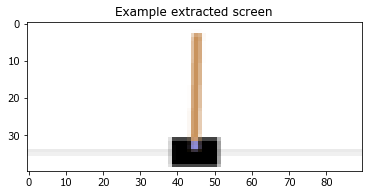

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen(env):
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen(env).cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

### Initialize Networks and optimizers

In [6]:
# Get screen resolution
init_screen = get_screen(env)
_, _, screen_height, screen_width = init_screen.shape

# Initialize police and target police networks (Solve bootstraping)
policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
# Make target network same as police network by loading same weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Initilize optimizer and replay buffer
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(replay_memory_size)


steps_done = 0

In [7]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)

In [8]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    display.clear_output(wait=True)
    #display.display(plt.gcf())

In [9]:
def optimize_model():
    # Wait buffer to be full of eperiences
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Train Loop

Complete


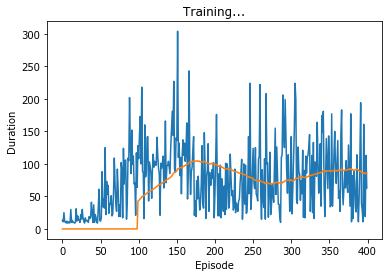

In [10]:
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen(env)
    current_screen = get_screen(env)
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen(env)
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            print('Episode:', i_episode)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
plot_durations()

### Test trained Agent

In [13]:
env.reset()
done = False
step = 0

# Calculate first state from previous 2 frames
last_screen = get_screen(env)
current_screen = get_screen(env)
state = current_screen - last_screen
    
while not done:
    
    #Q = q_func.forward(state)
    #action = tf.math.argmax(Q)
    #action = action.numpy()
    action = policy_net(state).max(1)[1].view(1, 1)
    
    _, reward, done, _ = env.step(action.item())
    
    # Calculate new state from previous 2 frames
    last_screen = current_screen
    current_screen = get_screen(env)
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None

    # Move to the next state
    state = next_state
    
    step += 1
    print("Step: {}".format(step))
    env.render()
    clear_output(wait=True)

Step: 32
